#Trajectory Forecasting using Transformers
In this project, we developed a trajectory prediction model based on the past position of the co-ordinates. The main idea of the project was to apply an encoder-decoder mechanism, from which we developed several approaches:

* a simple regression application
* a regression but using speed instead of position
* a Gaussian forecast approach, thus estimating only the parameters of a bivariate Gaussian in the plane.
* a quantified approach, thus based on 1000 clusters of movements used to predict classes of behaviour.

The main idea and development tools are from the paper of Luca Franco [Under the Hood of Transformer Networks for Trajectory Forecasting](https://arxiv.org/abs/2203.11878).

 

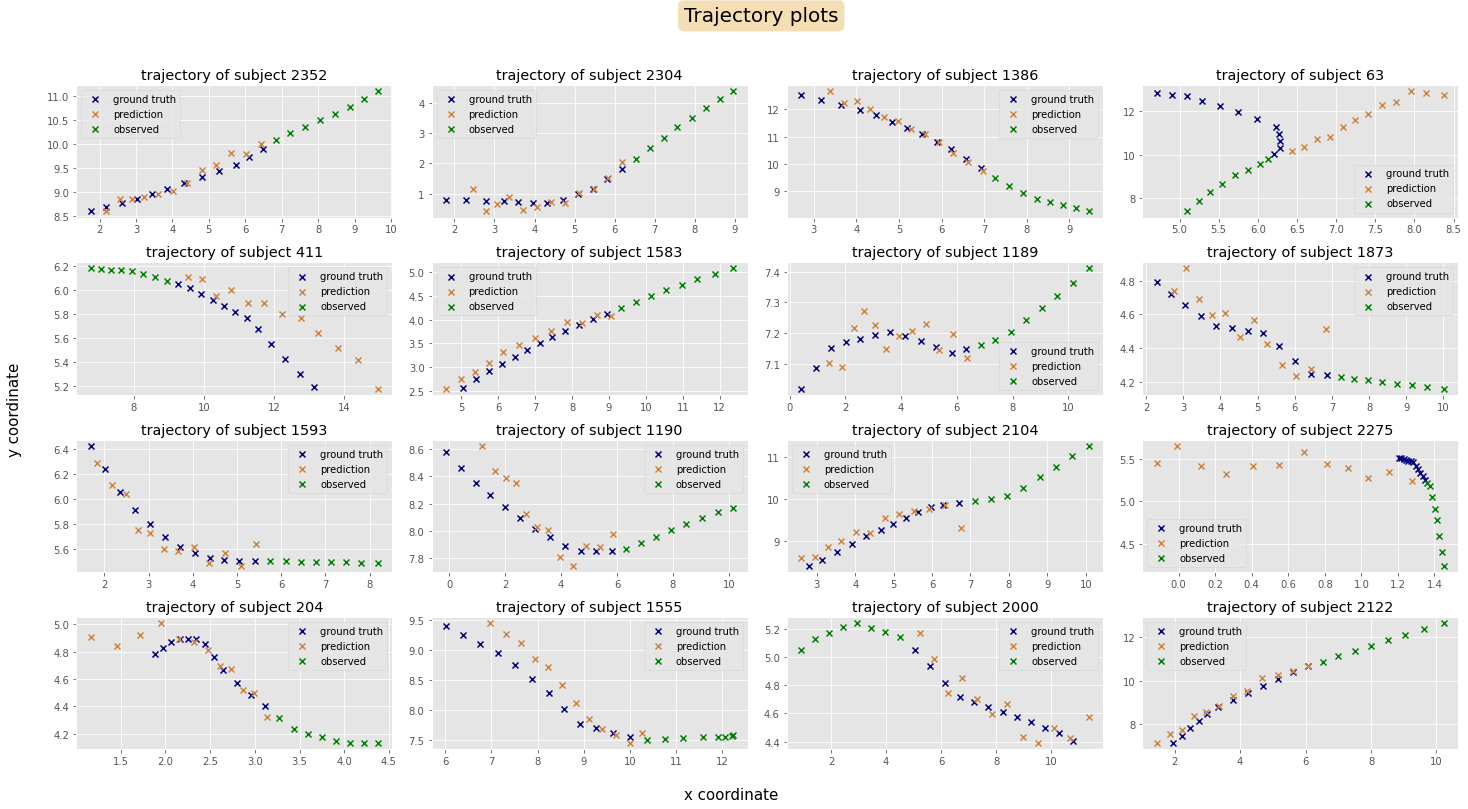

In [ ]:
grid_trajectories(history_score3, "test", ncol = 4, nrow = 4, random_subj=16, size=(20,10), marker='x')

# Initial setup

Only if you run from Google Colab run those 2 cells to sync with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TF4AML/

[Errno 2] No such file or directory: '/content/drive/MyDrive/TF4AML/'
/content


Start with the import

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import os
import time
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import pandas as pd
from matplotlib.ticker import PercentFormatter

from transformer import baselineUtils
from transformer import individual_TF
from transformer.batch import subsequent_mask
from transformer.noam_opt import NoamOpt


def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
def read_object(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

def get_memory():
  t = torch.cuda.get_device_properties(0).total_memory
  r = torch.cuda.memory_reserved(0)
  a = torch.cuda.memory_allocated(0)
  f = r-a  # free inside reserved

  print("Total memory:", t/1000/1000/1000)
  print("Reserved memory:", r/1000/1000/1000)
  print("Allocated memory:", a/1000/1000/1000)
  print("Free memory:", f/1000/1000/1000)

def free_memory():
  gc.collect()

  torch.cuda.empty_cache()

plt.style.use('ggplot')

In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


# Training and Testing

## Data Loading (setup the dataset for train, validation and test)

The subdatasets are 5 (ETH, Hotel, Univ, Zara1 and Zara2) we will leave one of them out for testing and train on the other 4. 

I.e. choosing ```dataset_name = 'zara1'``` the training set is composed by ETH, Hotel, Univ and Zara2 and tested on Zara1.

Moreover you can train and validate on a portion of the dataset setting percentage of the data (default is 50).

------ 

Each sequence is composed by an observed part to train the Encoder and a part we are attempting to predict with the Decoder. 

Generally the standard setup plans to use the first 8 points for the observation and the following 12 for the prediction.

------ 

Each created sequence has the shape (20, 4), where: 
- $N_{obs}+N_{pred} = 8 + 12 = 20$;
- Positions + Speeds = ( $x_i,\ y_i,\ u_i,\ v_i$) = ( $x_i,\ y_i,\ x_{i+1}-x_{i},\ y_{i+1} - y_i$ )

You can easily switch input type from position to speed setting the corresponding variable.

Speeds $u_i, v_i$ are generally more robust input and allow to avoid problems with the reference system.

------ 

Note: that $(u_0, v_0) = (0,0)$ and if speed are used the observed sequence has temporal length of $N_{obs} - 1$.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'regr'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading uni_examples_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading biwi_hotel_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_eth_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading students003_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading biwi_eth_val.txt
004 / 007 - loading crowds_zara03_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading students001_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

We compute the mean and standard deviation of positions or speeds across the full training dataset and use those to normalize each entry in the sequence.
This normalization is beneficial prior to processing with neural networks.

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

## Model instantiation

We create an instance of our transformer with the chosen configuration. 

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

## Training and Validation Step

Here we create two classes that define the single iteration function for train and validation.

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

## Optimizer

Here we select the **optimizer** proposed in the original Transformer Networks paper of Vaswani et al.

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Main 


Then we can train, validate and test our transformer epoch by epoch.

-------

The **losses** used are 2:

1.   $L_2$-loss distance between predicted $(\hat{\textbf{u}}, \hat{\textbf{v}})$ and GT $(\textbf{u}, \textbf{v})$ target speeds;
2.   $L_1$-loss for the target token mask. Note these should be all zero, so the loss is simply the mean.

-------

Moreover, the **metrics** used to validate the model goodness at Validation and Test time are the following:

1.   Mean Average Displacement (MAD): $L_2$-distance between *all* the $N_pred$ GT and predicted future ***positions***;
2.   Final Average Displacement (FAD): $L_2$-distance between the *last* GT and predicted future ***positions***;

-------

Note: If you restart the training for any reason, remember to instanciate again model and optimizer in order to reset them.

-------

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss

#Vector to store loss, MAD and FAD
from collections import defaultdict

history_score = defaultdict(list)

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    obs_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        obs_posit.append(batch['src'][:, :, 0:2])

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    obs_posit = np.concatenate(obs_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))

    history_score['loss_train'].append(train_loss/len(tr_dl))
    history_score['MAD_train'].append(mad)
    history_score['FAD_train'].append(fad)
    history_score['pr_posit_train'].append(pr_posit)
    history_score['gt_posit_train'].append(gt_posit)
    history_score['obs_posit_train'].append(obs_posit)


    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []
        obs_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            obs_posit.append(batch['src'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        obs_posit = np.concatenate(obs_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))

        history_score['loss_val'].append(val_loss/len(val_dl))
        history_score['MAD_val'].append(mad)
        history_score['FAD_val'].append(fad)
        history_score['pr_posit_val'].append(pr_posit)
        history_score['gt_posit_val'].append(gt_posit)
        history_score['obs_posit_val'].append(obs_posit)

    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        obs = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

        history_score['loss_test'].append(test_loss/len(test_dl))
        history_score['MAD_test'].append(mad)
        history_score['FAD_test'].append(fad)
        history_score['pr_posit_test'].append(pr)
        history_score['gt_posit_test'].append(gt)
        history_score['obs_posit_test'].append(obs)

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))
save_object(history_score, 'save_folder/regr/history_score_(factor_1_warmup_5_batch_512).pkl')

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 247.3014 - MAD:  0.3359 - FAD:  0.4955
Total Eval  Loss: 614.0884 - MAD:  1.0404 - FAD:  1.9789
Total Test  Loss: 753.1994 - MAD:  1.8584 - FAD:  3.1078 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 218.8850 - MAD:  0.2422 - FAD:  0.3057
Total Eval  Loss: 450.3620 - MAD:  0.7817 - FAD:  1.3540
Total Test  Loss: 546.8019 - MAD:  1.4924 - FAD:  2.2320 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 112.8664 - MAD:  0.1381 - FAD:  0.2057
Total Eval  Loss: 340.1068 - MAD:  0.5783 - FAD:  1.4091
Total Test  Loss: 319.8798 - MAD:  0.5263 - FAD:  1.2496 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 112.9622 - MAD:  0.1445 - FAD:  0.2209
Total Eval  Loss: 278.9361 - MAD:  0.4782 - FAD:  1.1387
Total Test  Loss: 307.2302 - MAD:  0.4853 - FAD:  1.1583 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 103.7643 - MAD:  0.1235 - FAD:  0.1825
Total Eval  Loss: 258.2

## Load a model


Here we leave a snippet of code to quickly load a model from a saved checkpoint. You can load model at specific epoch using this code before the main train-eval-test loop.

In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 2048
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 50
dataset_name = 'zara1'

path = f'save_folder/{dataset_name}/{(epoch):05d}.pth'
model.load_state_dict(torch.load(path))


# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 10

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1

## Visualization

Here you can implement some function to create qualitative plots.

We recommend you the following:

1. Loss plot for Train, Eval and Test;
2. MAD plot for Train, Eval and Test;
3. FAD plot for Train, Eval and Test;
4. Trajectory positions (observed points, GT target points and predicted target points)

In [ ]:
# Here your code 
# Function that plot a single trajectory plot for one subject
#     data: dictionary containing the coordinates data of the model
#     colors: list of string containing named colors of matplotlib
#     ax: axe of a pyplot object
#
def trajectory_plot(data, key = "test", epoch=39, subj = 5, ax=None, colors=['green', 'navy', 'peru'], **kargs):

  #If an axe is not passed, create one
  if ax is None:
    plt.figure(figsize=(10,5))
    ax = plt.gca()

  #Plot scatter of ground truth coordinates
  ax.scatter(data['gt_posit_' +key][epoch][subj, :, 0], data['gt_posit_train'][39][subj, :, 1], color=colors[1], label = 'ground truth', **kargs)
  #Plot scatter of predicted coordinates
  ax.scatter(data['pr_posit_'+key][epoch][subj, :, 0], data['pr_posit_train'][39][subj, :, 1], color=colors[2],  label = 'prediction', **kargs)
  #Plot scatter of observed coordinates
  ax.scatter(data['obs_posit_'+key][epoch][subj, :, 0], data['obs_posit_train'][39][subj, :, 1], color=colors[0], label ='observed', **kargs)

  ax.legend()
  ax.set_xlabel('x coordinate')
  ax.set_ylabel('y coordinate')
  ax.set_title(f'trajectory of subject {subj}')

  return ax

#Function that take as input a number of subject to plot or the specific subjects.
#     data: dictionary containing the coordinates data of the model
#     nrow: number of rows for the final plot
#     ncol: number of columns for the final plot
#     s,e:  n subject of the data to plot. If subj is specified, this input is ignored
#     subj: list containing the specific subject to plot as index of the data. If None, n is used.
#     colors: list of string containing named colors of matplotlib
#     
def grid_trajectories(data, key = "test", epoch=39, nrow=2, ncol=2,s=0, e=3, subj = None, random_subj= None, size=(10,10), colors=['green', 'navy', 'peru'], **kargs):
  # Initialization of the plot
  figure, axes = plt.subplots(nrow,ncol, figsize=size)

  #If subj is not passed, plot the first n subject of the data
  if(subj is None and random_subj is None):
    for axe, el in zip(axes.flatten(), range(s,e)):
      trajectory_plot(data, key, epoch, el, ax=axe, colors=colors, **kargs)
      # remove the labels from the trajectory plot
      axe.set_xlabel('')
      axe.set_ylabel('')

  #If subj is passed, select those specific subjects
  elif(subj is not None):
    for axe, el in zip(axes.flatten(), subj):
      trajectory_plot(data, key, epoch, el, ax=axe, colors=colors, **kargs)
      # remove the labels from the trajectory plot
      axe.set_xlabel('')
      axe.set_ylabel('')
  
  #If subj is None then random sample subjects from the data
  else:
    subj = random.sample(set(np.arange(data['obs_posit_'+key][epoch].shape[0])), random_subj)
    for axe, el in zip(axes.flatten(), subj):
      trajectory_plot(data, key, epoch, el, ax=axe, colors=colors, **kargs)
      # remove the labels from the trajectory plot
      axe.set_xlabel('')
      axe.set_ylabel('')

  
  figure.tight_layout()
  # Add title and new labels to the plot
  figure.text(0.45,1.05, 'Trajectory plots', bbox=dict(boxstyle='round', facecolor='wheat'), fontdict=dict(size=20))
  figure.text(0.45,-0.03, 'x coordinate', fontdict=dict(size=15))
  figure.text(-0.02, 0.45, 'y coordinate', fontdict=dict(size=15), rotation='vertical')

# Function that plot the traceplot of loss mad and fad
#     data: dictionary containing the coordinates data of the model
#     figsize: size of the final image
#     colors: list of string containing named colors of matplotlib
def trace_plots(data, figsize=(12,6), colors=['green', 'navy', 'peru'], **kargs):
  plt.figure(figsize=(12, 6))
  ax1 = plt.subplot(2,2,1)
  ax2 = plt.subplot(2,2,2)
  ax3 = plt.subplot(2,1,2)
  axes = [ax1, ax2, ax3]




  axes[0].set_title('FAD')
  axes[0].plot(data['FAD_train'], label = 'train', color = colors[0], **kargs)
  axes[0].plot(data['FAD_val'], label= 'val', color = colors[1], **kargs)
  axes[0].plot(data['FAD_test'], label= 'test', color = colors[2], **kargs)
  axes[0].legend()

  axes[1].set_title('MAD')
  axes[1].plot(data['MAD_train'], label ='train', color = colors[0], **kargs)
  axes[1].plot(data['MAD_val'], label='val', color = colors[1], **kargs)
  axes[1].plot(data['MAD_test'], label='test', color = colors[2], **kargs)
  axes[1].legend()

  axes[2].set_title('LOSS')
  axes[2].plot(data['loss_train'], label = 'train', color = colors[0], **kargs)
  axes[2].plot(data['loss_val'], label = 'val', color = colors[1], **kargs)
  axes[2].plot(data['loss_test'], label = 'test', color = colors[2], **kargs)
  axes[2].legend()

  return axes

def compare_models(data,ax=None):

  if ax is None:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
  else:
    ax1, ax2 = ax
  
  labels = []
  for index, row in data[data.columns[:3]].iterrows():
    labels.append(f"factor{row[1]} warmup {row[2]} batch {row[0]}")

  labels

  data.filter(regex=("loss*")).transpose().plot.bar(ax=ax1);
  data.filter(regex=(".AD*")).transpose().plot.bar(ax=ax2);
  ax1.legend(labels)
  ax2.legend(labels)

  return ax1, ax2

def distribution_error_plot(data, data2, category = 'test', coords=[5,0.5], labels = ['1', '2'], alpha = 0.6, ax=None):
  if ax is None:
    plt.figure(figsize=(10,5))
    ax = plt.gca()

  a = list(map(np.linalg.norm, data["gt_posit_" + category][39]-data["pr_posit_" + category][39]))
  b = list(map(np.linalg.norm, data2["gt_posit_"+ category][39]-data2["pr_posit_" + category][39]))

  ax.hist(a,np.arange(15), weights=np.ones(len(a)) / len(a), label= labels[0], edgecolor='k');
  ax.hist(b,np.arange(15), weights=np.ones(len(b)) / len(b),  label = labels[1], alpha=alpha, edgecolor='k');

  ax.yaxis.set_major_formatter(PercentFormatter(1))

  loss1 = data['loss_'+category][39]
  loss2 = data2['loss_'+ category][39]
  ax.text(coords[0], coords[1], f"loss {labels[0]}: {np.round(loss1, 4)}\nloss {labels[1]}: {np.round(loss2, 4)}")


  ax.set_xlabel('Euclidean distance from the ground truth')
  ax.set_ylabel('Count')
  ax.set_title('Residual diagnostics')
  ax.legend()

  return ax

In [ ]:
history_score = read_object('save_folder/regr/history_score_(factor_1_warmup_5_batch_512).pkl')

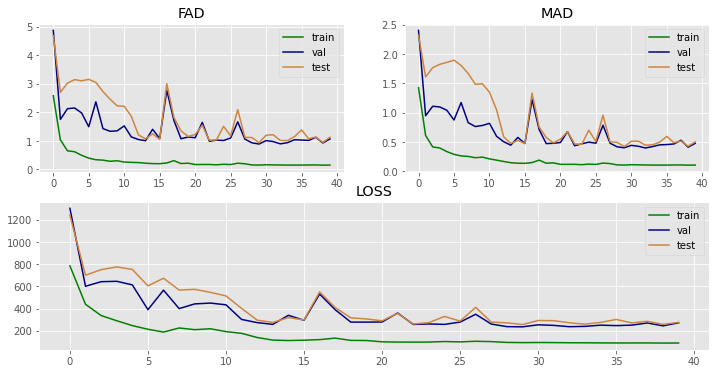

In [ ]:
trace_plots(history_score);

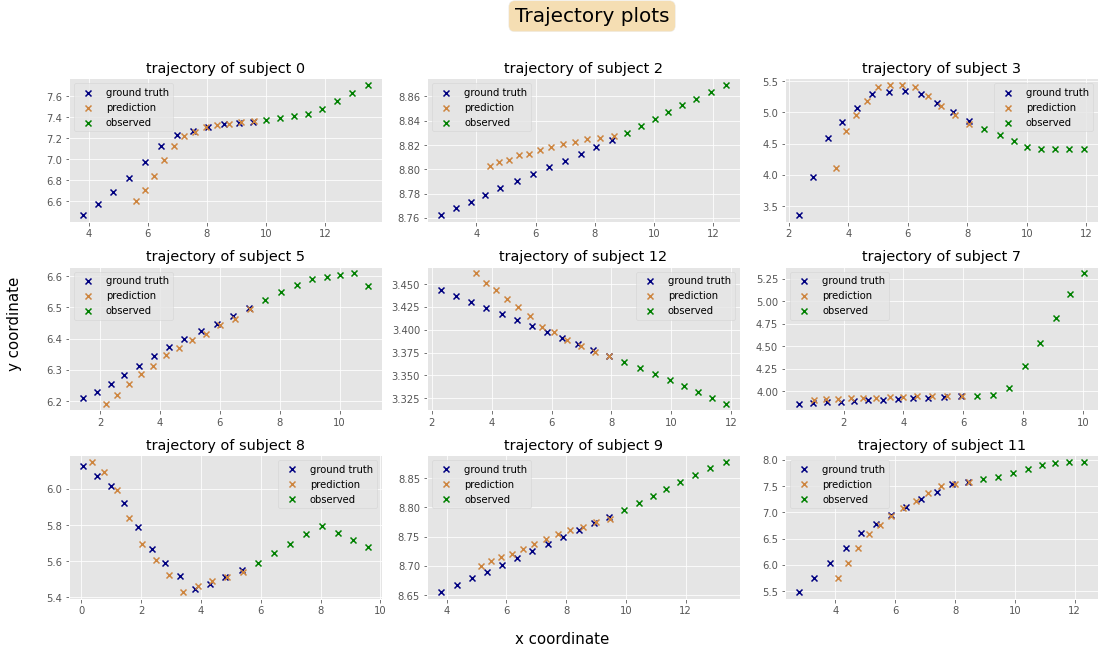

In [ ]:
grid_trajectories(history_score, ncol=3, nrow=3, subj=[0,2,3,5,12,7,8,9,11], size=(15,8), marker='x')

## Report


Here you can report comments and results for the experiments up to this point.

Perform experiments that improves the performances or that gives meaningfull insights.

I.e. what happens if we change model hyperparamenters? What if we change learning rate?

Please explain extensively the results and organize them clearly with tables, plots...

----

Generally the space of the hyperparameters tried during our simulatuons has showned that there aren't significant changes in the results. As an example we tried to modify the learning rate changing the factor and warmup parameters. We achive just a small improvement rising the learning rate. 

This implies that this type of model is quite robust to the setting of the parametrization. Despite the previous statement, handling small changes in the value of the batch size parameter we are obtaining significant improvement in the train-validation-test loss.

As showen in the plot below, using a smaller value of butch size like 256, both in the loss and metrics, we reach better results. In particular the scale in the improvement is pretty different comparing the loss and the metrics: Meanwhile loss as a great decay with respect to the others implementation, on the metrics we observe a moderate reduction.

Looking our findings the model seems to achive better result with a batch size of 256 and a lr of ... for this kind of task.


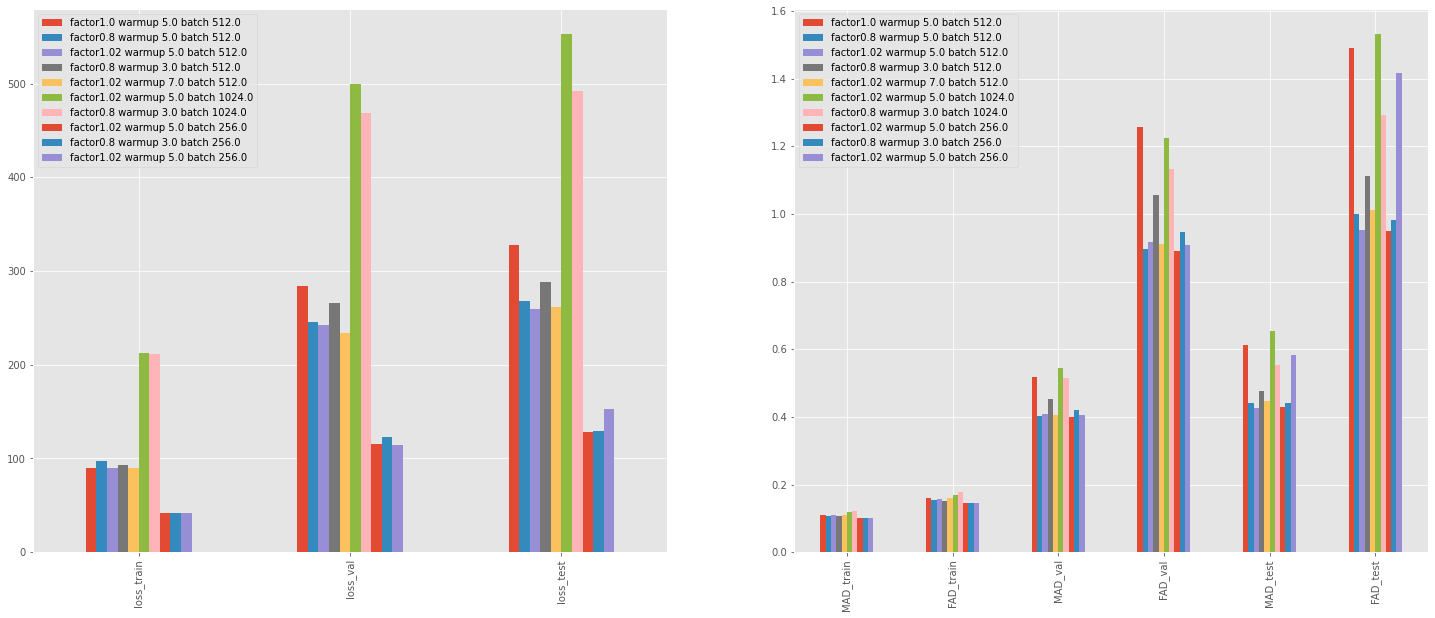

In [ ]:
df = pd.read_csv("save_folder/regr/base_results.csv", index_col=0)
history_score = read_object('save_folder/regr/history_score_(factor_1_warmup_5_batch_512).pkl')
history_score2 = read_object('save_folder/regr/history_score_(factor_102_warmup_5_batch_256).pkl')

compare_models(df);

# Ablation Studies


Here we ask you to change some settings in order to compare the benefit of some specific mechanism.

Please follow the instructions and create a small report for each point adding your comments supported by plots, tables with results or whatever you think is usefull.

Each extra study included to improve general performance or to draft a more complete analysis will be considered.

---

**Note:** to have a fair comparison we suggest to fix the setup (i.e. Regressive TF with speeds, obs=8, pred=12, ...) and change just the analysed module.

---

## 1. Substitute for the Prediction Framework

---

The standard task is the regression of future speeds/positions. 

We propose to implement to different frameworks: Gaussian and Quantized.

---

### a.  Gaussian


Predicting normal distribution parameters mean vector $\mu = (\mu_x, \mu_y)$ and covariance matrix $\Sigma = \biggl( \begin{smallmatrix}\sigma_x^2 & \rho \sigma_x \sigma_y\\ \rho \sigma_x \sigma_y & \sigma_y^2 \end{smallmatrix}\biggr)$ of future predicition. 

Then the model output dimension is 5: 2 for mean parameters $\mu_x, \mu_y$ and 3 for the covariance parameters $\sigma_x, \sigma_y, \rho$.

---

Note: consider carefully the following code snippet. In this way we force $\sigma_x, \sigma_y$ to be positive and $\rho$ to be in $[-1, 1]$

The following lines are meant to be a hint. Integrate those into the code of the previous cells.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'gauss'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

In [ ]:
model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

output = model(inp, dec_inp, src_att, trg_att)

mux = output[:, :, 0].unsqueeze(2)
muy = output[:, :, 1].unsqueeze(2)
sx = torch.exp(output[:, :, 2]).unsqueeze(2)
sy = torch.exp(output[:, :, 3]).unsqueeze(2)
corr = torch.tanh(output[:, :, 4]).unsqueeze(2)

mean = torch.cat((mux, muy), dim=2).to(device)
cov = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)

Next prediction can be now sampled from the predicted distribution making the forecasting stochastic.

The loss used in this case is the NLL.  

Note: To relax the assumption you can also use predicted mean as input for following step (particularly in eval and test), avoiding the sampling and assuming identity as covariance matrix.

In [ ]:
# Here your code 

#### Results

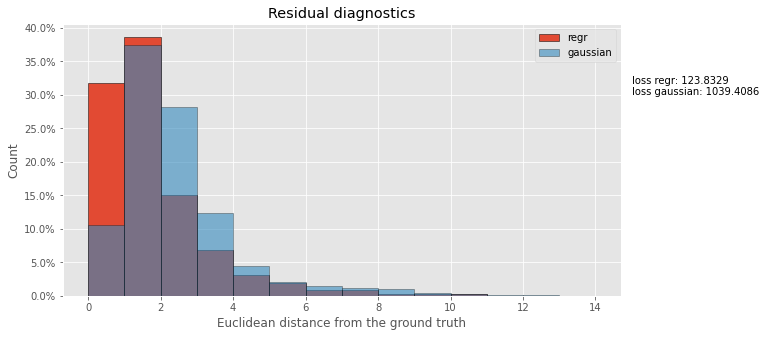

In [ ]:
history_score5 = read_object('save_folder/history_score_gaussian.pkl')
history_score4=read_object('save_folder/regr/history_score_(factor_102_warmup_5_batch_256).pkl')
distribution_error_plot(history_score4, history_score5, coords = [15, 0.3], labels=['regr', 'gaussian']);


This plot explain how distances from prediction is distribuited among each observation.
Since that the average error is higher we are obtaining a shifted median on the distribution of distances, but also in term of range they are pretty similar; so they are approaching the anomaly values in the same way. 

Here your report

---

### b. Quantized

Transformer was originally introduced in the NLP i.e. for next word classification task.
    
To emulate this case we change dataset (clustering all possible speed in C classes) and model to classify the most likely one (with CE loss).

Here we provide a script for the quantized dataset, so you may adapt the final part of the model to output probability score for each class (output_size=1000 + softmax) followed by CE loss.

---

Note: In the quantized framework the start of sequence token is adapted: 

The class indices spans from 0 to 999, so we add index 1000 to represent the start of sequence token

The following lines are meant to be hint, wisely integrate them with the code in the previous cells.  

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'quant'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# Load precomputed clusters to quantize the data
mat = scipy.io.loadmat(os.path.join('datasets', dataset_name, "clusters.mat"))
clusters=mat['centroids']
num_classes = clusters.shape[0]

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

In [ ]:
batch_size = 256

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = num_classes
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = num_classes+1
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = num_classes

emb_size = 64
ff_size = 128
heads = 1
layers = 1
dropout = 0.7


model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 0.1
warmup = 1

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
def train_step(model, batch, device):
  
  # Inside the train and eval step we need to convert speed/position to cluster index
  batch_size = batch['src'].shape[0]

  # Associate the nearest class to each speed/position
  speeds_inp=batch['src'][:,1:,2:4]
  inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

  inp = F.one_hot(inp, num_classes = 1000).to(torch.float)

  speeds_trg = batch['trg'][:,:-1,2:4]
  target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

  # Class are indices from 0 to 999. 
  # We add index 1000 to represent the start of sequence token
  start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)


  dec_inp = torch.cat((start_of_seq, target), 1)

  dec_inp = F.one_hot(dec_inp, num_classes=1001).to(torch.float)

  src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
  trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

  output = model(inp, dec_inp, src_att, trg_att)


  return output

def eval_step(model, batch, device, preds=12):

    batch_size = batch['src'].shape[0]
    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    speeds_inp=batch['src'][:,1:,2:4]
    inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
    
    inp = F.one_hot(inp, num_classes = 1000).to(torch.float)

 
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)
    dec_inp = F.one_hot(start_of_seq, num_classes = 1001).to(torch.float)

    #predictions_logits = torch.ones((batch_size,1,1000)).to(device)
    loss = 0
    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)

        #predictions_logits = torch.cat((predictions_logits, out[:, -1:, :]), 1).to(device)
        gt_speed = torch.tensor(scipy.spatial.distance.cdist(batch['trg'][:,i,2:4].reshape(-1, 2), clusters).argmin(axis=1).reshape(batch['trg'].shape[0], -1)).to(device)
        loss += F.cross_entropy(out[:, -1:, :].contiguous().view(-1, num_classes), gt_speed.contiguous().view(-1), reduction='mean')

        out = F.one_hot(torch.argmax(F.softmax(out[:, -1:, :], -1), -1), num_classes=1001).to(torch.float)
        dec_inp = torch.cat((dec_inp, out), 1)

    return dec_inp[:, 1:, :-1], loss/preds

####Train

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 1           # Frequency for printing the loss

#Vector to store loss, MAD and FAD
from collections import defaultdict

history_score = defaultdict(list)

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    obs_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, device)
        gt_speed = torch.tensor(scipy.spatial.distance.cdist(batch['trg'][:,:,2:4].reshape(-1, 2), clusters).argmin(axis=1).reshape(batch['trg'].shape[0], -1)).to(device)
        
        loss = F.cross_entropy(pred_speed.view(-1, num_classes), gt_speed.view(-1), reduction='mean')


        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(F.softmax(pred_speed, -1), 2).cpu().numpy()].cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            #preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
            pass
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        obs_posit.append(batch['src'][:, :, 0:2])

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    obs_posit = np.concatenate(obs_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))

    history_score['loss_train'].append(train_loss/len(tr_dl))
    history_score['MAD_train'].append(mad)
    history_score['FAD_train'].append(fad)
    history_score['pr_posit_train'].append(pr_posit)
    history_score['gt_posit_train'].append(gt_posit)
    history_score['obs_posit_train'].append(obs_posit)


    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []
        obs_posit = []

        for id_b, batch in enumerate(val_dl):
    
            pred_speed, loss = eval_step(model, batch, device, preds=preds_num)
            #gt_speed = torch.tensor(scipy.spatial.distance.cdist(batch['trg'][:,:,2:4].reshape(-1, 2), clusters).argmin(axis=1).reshape(batch['trg'].shape[0], -1)).to(device)


            #loss = F.cross_entropy(pred_speed.contiguous().view(-1, num_classes), gt_speed.contiguous().view(-1), reduction='mean')
          

            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                #preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(F.softmax(pred_speed, -1), 2).cpu().numpy()].cumsum(1)
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(pred_speed, -1).cpu().numpy()].cumsum(1)
            elif input_type == 'position':
                #preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
                pass
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            obs_posit.append(batch['src'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        obs_posit = np.concatenate(obs_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))

        history_score['loss_val'].append(val_loss/len(val_dl))
        history_score['MAD_val'].append(mad)
        history_score['FAD_val'].append(fad)
        history_score['pr_posit_val'].append(pr_posit)
        history_score['gt_posit_val'].append(gt_posit)
        history_score['obs_posit_val'].append(obs_posit)

    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        obs = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed, loss = eval_step(model, batch, device, preds=preds_num)
            #gt_speed = torch.tensor(scipy.spatial.distance.cdist(batch['trg'][:,:,2:4].reshape(-1, 2), clusters).argmin(axis=1).reshape(batch['trg'].shape[0], -1)).to(device)

            #loss = F.cross_entropy(pred_speed.contiguous().view(-1, num_classes), gt_speed.contiguous().view(-1), reduction='mean')


            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                #preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(F.softmax(pred_speed, -1), 2).cpu().numpy()].cumsum(1)
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(pred_speed, -1).cpu().numpy()].cumsum(1)
            elif input_type == 'position':
                #preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
                pass

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

        history_score['loss_test'].append(test_loss/len(test_dl))
        history_score['MAD_test'].append(mad)
        history_score['FAD_test'].append(fad)
        history_score['pr_posit_test'].append(pr)
        history_score['gt_posit_test'].append(gt)
        history_score['obs_posit_test'].append(obs)

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/quantized_{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))
#save_object(history_score, 'save_folder/quant/history_score_quantized(factor_01_warmup_0_batch_256).pkl')

#### Results

In [ ]:
history_score2 = read_object('save_folder/quant/history_score_quantized_batch_256.pkl')
history_score4=read_object('save_folder/regr/history_score_(factor_102_warmup_5_batch_256).pkl')

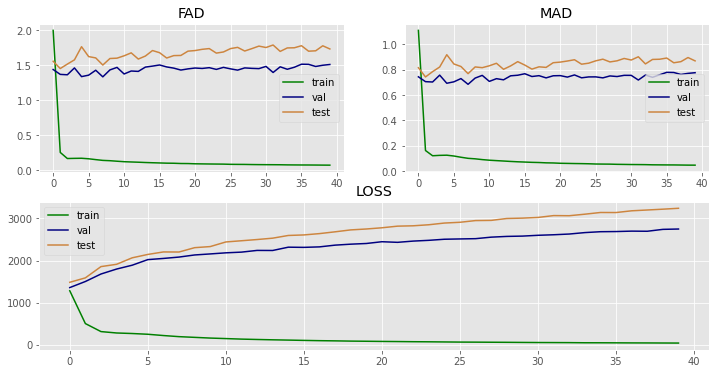

In [ ]:
trace_plots(history_score2);

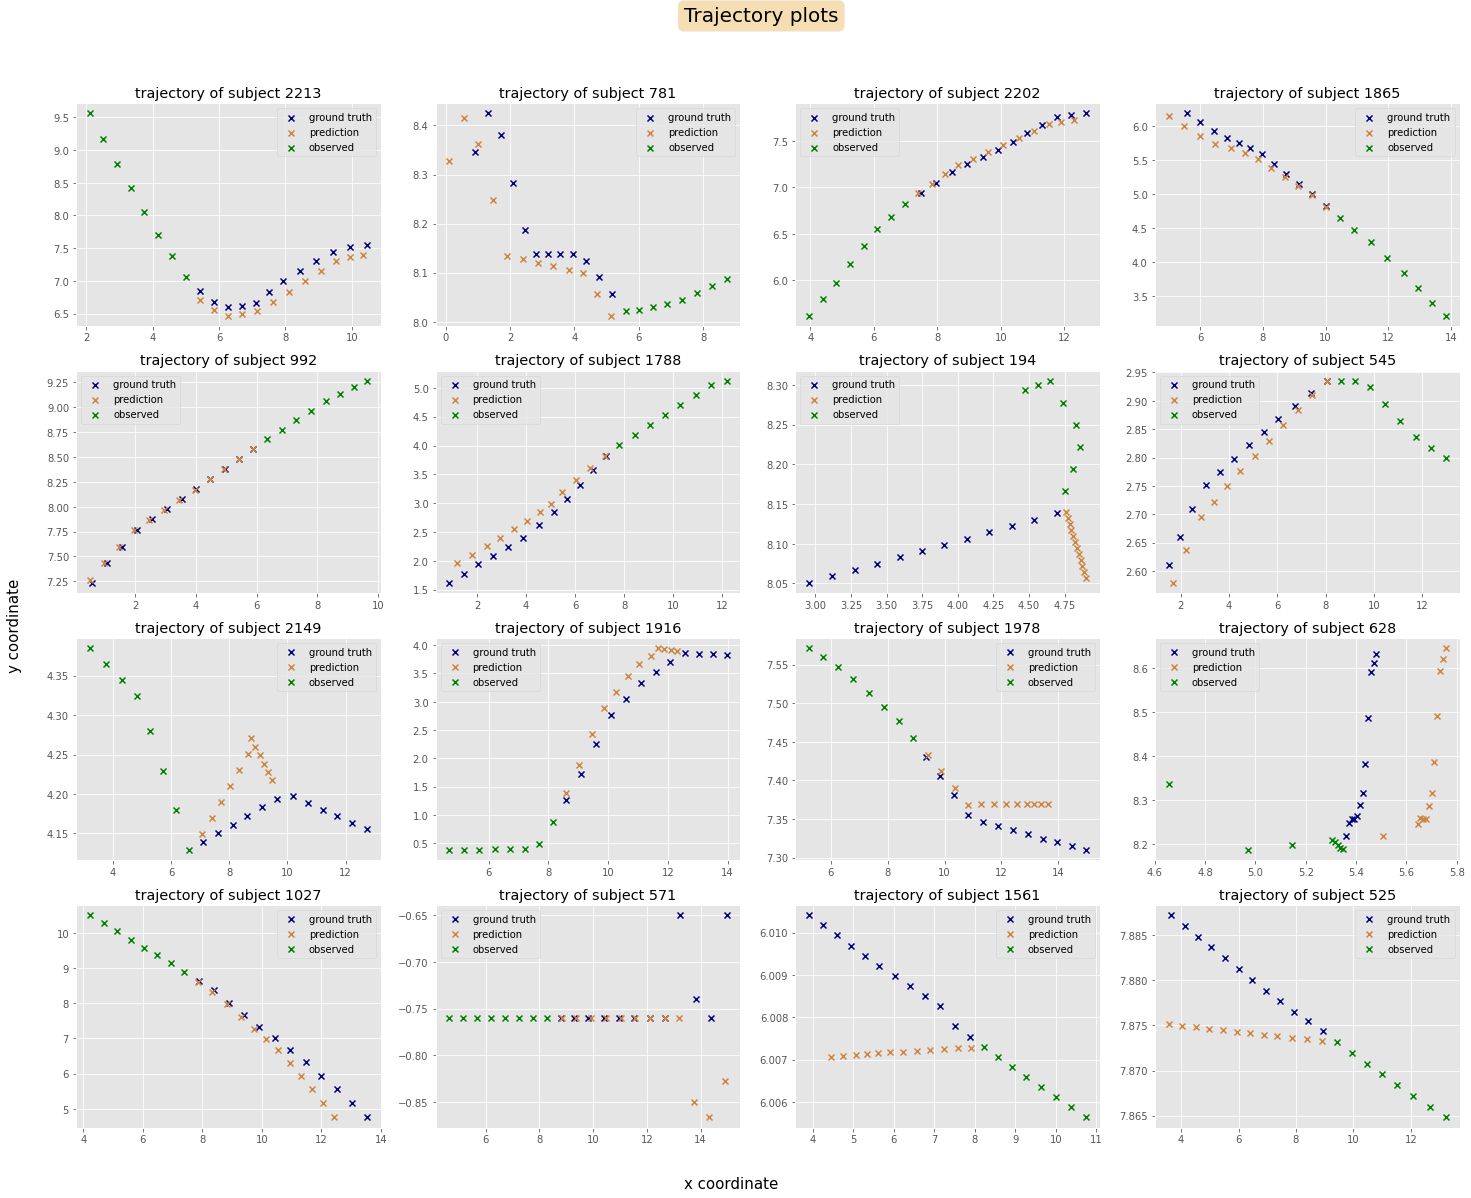

In [ ]:
grid_trajectories(history_score2, "test", ncol = 4, nrow = 4, random_subj=16, size=(20,15), marker='x')

Despide the good learning of the model highlight by the decreasing loss on the training, the validation and the test losses keep increasing. This highlight an overfitting scenario.
The overfitting can be spotted by looking at the trajectory plot; observing the subject number 1561 and 525 we can clearly see how without any reason after a straight line observed the predictions curve anomaly both in the same direction, probabluy following a probable patter in the train data.
We tried to change the hyperparameters and also the model structure (layers, emb_size, ff_size, ...) in order to avoid the overfitting but no configuration lead to a good result.

Another interesting aspect to highlight are the MAD and FAD metrics that fluctuate around acceptable values.



## 2. Increase Prediction Horizon (Short- or Long-term Forecasting) 

---

You can easily increase/decrease the number of predictions (i.e. pred = 4, 8, 12, 20, 30, 50 ....) in the dataloader and see the effect on the MAD/FAD metric.

Report your results in a table and/or plot and comment what you see.

---

In [ ]:
# Here your code 

Here your report

---

## 3. Increasing Data Number 

Transformers are generally very large network and need a lot of data to perform well.

Try to vary the percentage data variable (i.e. 10, 25, 50, 75, 100) and see how the performance changes.

Please report here plots and/or tables for:

1. MAD and FAD metrics 

2. Computational time

In [ ]:
# Here your code 

Here your report

---

## 4. Change input Type

---

What happens if we change the input form speed type (u,v) to position one (x,y)?

Report then some quantitative results and plot trajectory predicted with both method to evaluate qualitative differences.

---

In [ ]:
# Here your code 

df2 = pd.read_csv("save_folder/regr_position/position_results.csv", index_col=0)
history_score4=read_object('save_folder/regr/history_score_(factor_102_warmup_5_batch_256).pkl')
history_score3 = read_object('save_folder/regr_position/history_score_(factor_102_warmup_5_batch_256).pkl')

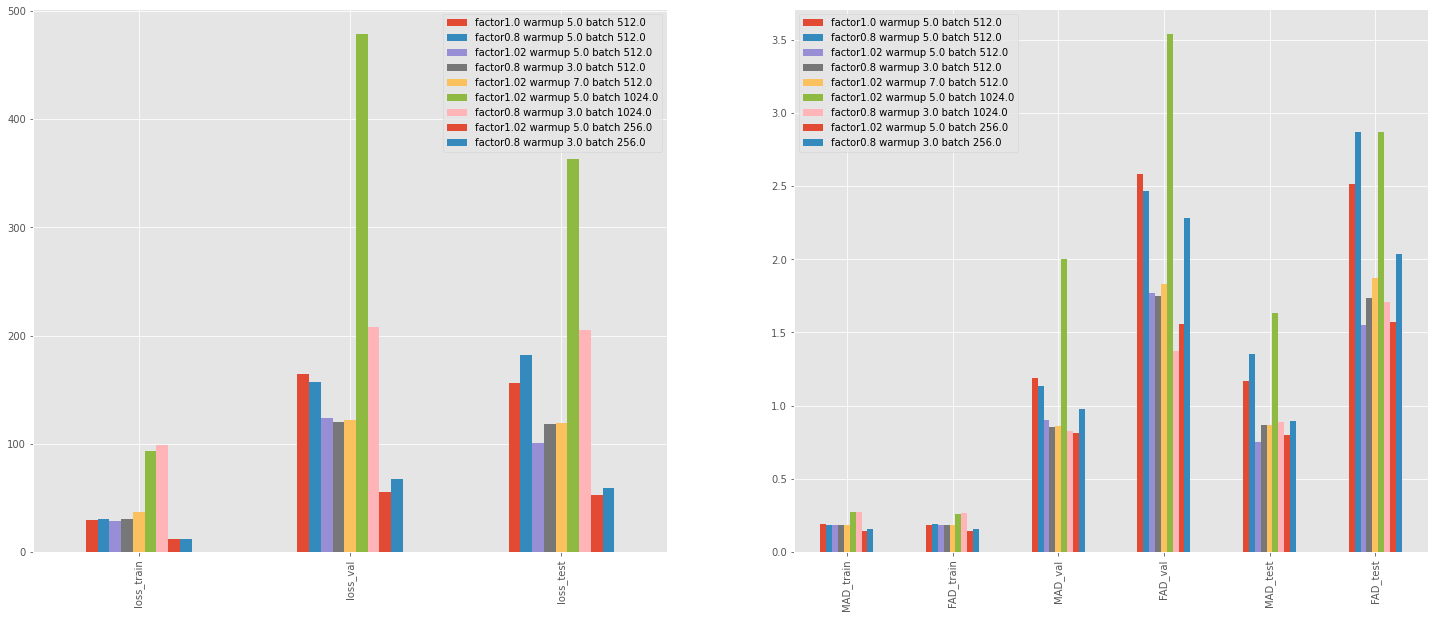

In [ ]:
compare_models(df2);

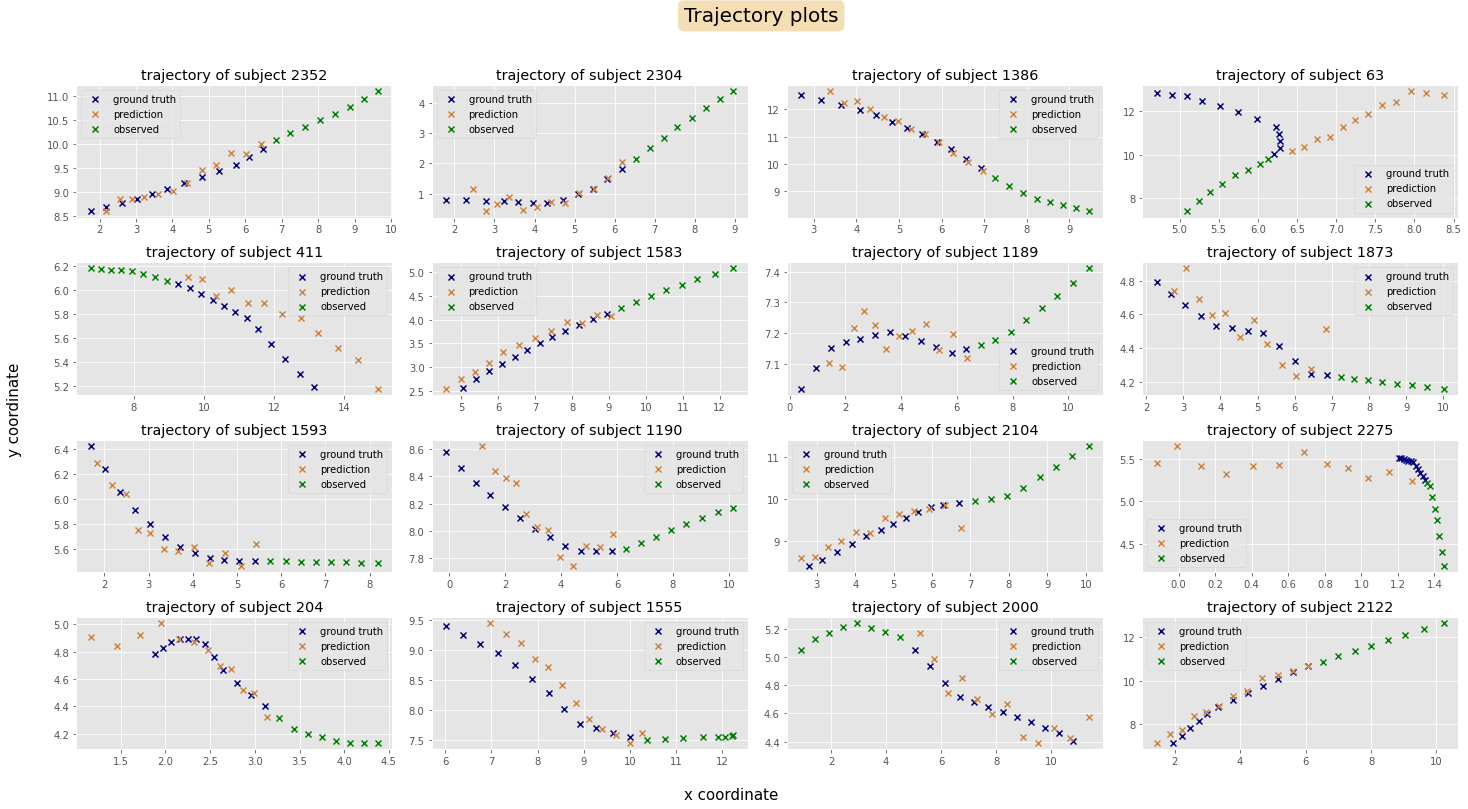

In [ ]:
grid_trajectories(history_score3, "test", ncol = 4, nrow = 4, random_subj=16, size=(20,10), marker='x')

The new input type for the model dosen't seems to influence the choice for the hyperparameters; the best choices remain the same as the speed model (batch size of 256 and higher learning rate). However the general performace of the model appear to be getting worst as also highlighted in the paper.

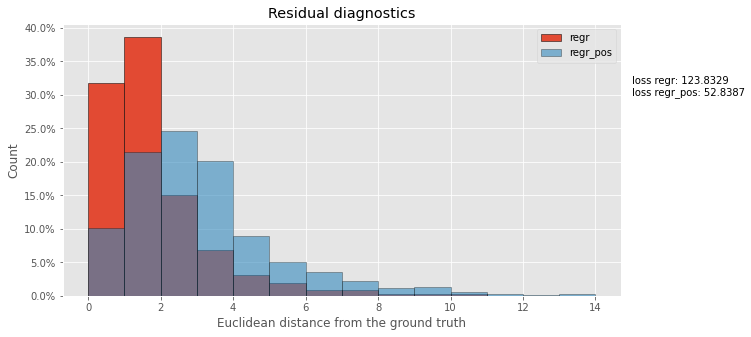

In [ ]:
distribution_error_plot(history_score4, history_score3, coords = [15, 0.3], labels=['regr', 'regr_pos']);

Obviously as discussed previously using as imput the position we obtain a worst result, this is visuble from the shifted distribution of the euclidean distance for each individual; and still from this plot we can affirm that this second model fit defenely less precisly also the anamalies, because it raise a heavy tail on the blue distribution.

## 5. Positional Encoding 

A number of positional encodings have been proposed. 

Implement the plain positional encoding [0,1,2,3,4,...] and report your comments and results.

Change the commented class we prepared in the positional_encoding.py file and copy the class here. 

In [ ]:
class PositionalEncoding(nn.Module):
    """
    You can use this class to create another positional encoding to your input.
    Remember to comment previous class.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        pe[:, 0::2] = position
        pe[:, 1::2] = position
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [ ]:
input_type="speed"
if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

batch_size = 256

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, 
                                   N=layers, d_model=emb_size, d_ff=ff_size, h=heads, 
                                   dropout=dropout).to(device)
#optimizer                                  
factor = 1.2
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss



regr_checkpoint = {
        'train' : {'loss': [], 'MAD': [], 'FAD' : []},
        'val' : {'loss': [], 'MAD': [], 'FAD' : []},
        'test' : {'loss': [], 'MAD': [], 'FAD' : [], 'obs': [], 'gt': [], 'pr': []}
    }


print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []

    
  
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

      


        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2


        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_😎
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)


        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)


    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    regr_checkpoint['train']['MAD'].append(mad)
    regr_checkpoint['train']['FAD'].append(fad)



    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))

    # Take trace of the loss values
    regr_checkpoint['train']['loss'].append(train_loss/len(tr_dl))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []


        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
  

            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        

        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        regr_checkpoint['val']['MAD'].append(mad)
        regr_checkpoint['val']['FAD'].append(fad)

        

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))

        # Take trace of the loss values
        regr_checkpoint['val']['loss'].append(val_loss/len(val_dl))




    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        obs = []


        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        regr_checkpoint['test']['MAD'].append(mad)
        regr_checkpoint['test']['FAD'].append(fad)
       

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))
        
        # Take trace of the loss values
        regr_checkpoint['test']['loss'].append(test_loss/len(test_dl))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')

    if epoch == max_epoch-1:
      regr_checkpoint['test']['gt'] = gt
      regr_checkpoint['test']['pr'] = pr
      regr_checkpoint['test']['obs'] = obs



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))
save_object(regr_checkpoint,  f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}QUELLOB.pkl')


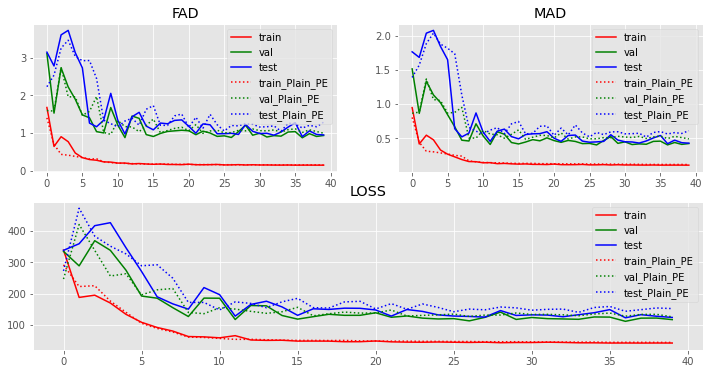

In [ ]:
data = read_object("/content/drive/MyDrive/HW3/TF4AML-master/save_folder/regr/history_score_(factor_102_warmup_5_batch_256).pkl")
data2= read_object("/content/drive/MyDrive/HW3/TF4AML-master/save_folder/Plain_PE/zara1/00040QUELLOB.pkl")


plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3]

colors=["red","green","blue"]
data2

axes[0].set_title('FAD')
axes[0].plot(data["FAD_train"], label = 'train', color = colors[0],)
axes[0].plot(data["FAD_val"], label= 'val', color = colors[1])
axes[0].plot(data["FAD_test"], label= 'test', color = colors[2] )
axes[0].plot(data2["train"]["FAD"], label = 'train_Plain_PE', color = colors[0],linestyle = 'dotted')
axes[0].plot(data2["val"]["FAD"], label= 'val_Plain_PE', color = colors[1],linestyle = 'dotted')
axes[0].plot(data2["test"]["FAD"], label= 'test_Plain_PE', color = colors[2] ,linestyle = 'dotted')
axes[0].legend()

axes[1].set_title('MAD')
axes[1].plot(data["MAD_train"], label ='train', color = colors[0] )
axes[1].plot(data["MAD_val"], label='val', color = colors[1] )
axes[1].plot(data["MAD_test"], label='test', color = colors[2] )
axes[1].plot(data2["train"]["MAD"], label ='train_Plain_PE', color = colors[0] ,linestyle = 'dotted')
axes[1].plot(data2["val"]["MAD"], label='val_Plain_PE', color = colors[1],linestyle = 'dotted' )
axes[1].plot(data2["test"]["MAD"], label='test_Plain_PE', color = colors[2] ,linestyle = 'dotted')
axes[1].legend()

axes[2].set_title('LOSS')
axes[2].plot(data["loss_train"], label = 'train', color = colors[0] )
axes[2].plot(data["loss_val"], label = 'val', color = colors[1] )
axes[2].plot(data["loss_test"], label = 'test', color = colors[2] )
axes[2].plot(data2["train"]["loss"], label = 'train_Plain_PE', color = colors[0] ,linestyle = 'dotted')
axes[2].plot(data2["val"]["loss"], label = 'val_Plain_PE', color = colors[1] ,linestyle = 'dotted')
axes[2].plot(data2["test"]["loss"], label = 'test_Plain_PE', color = colors[2] ,linestyle = 'dotted')
axes[2].legend()

axes

Using a plain positional encoding, instead of the positional encoding suggested by the paper "Attention is all you need", we are reaching a worst result boh in term of loss function (higher) and metrics (FAD and MAD).
Comparing these results just on the train set we notice that the values are pretty the same, nut instead the distamce is significant if we refere to the test and validation set.
That's because we are just inserting a vector of id of position for all the observed data (first 8 poaitiona).



